<div class="alert alert-info">
<u><strong>Author</strong></u>: <b>Alberto Vavassori</b> (alberto.vavassori@polimi.it) - DICA - Politecnico di Milano - GIS GEOLab <br>
Developed within the LCZ-ODC project, funded by the Italian Space Agency (agreement n. 2022-30-HH.0).
</div>

# Plotting - data exploration and visualization

<a id='TOC_TOP'></a>
Notebook structure:  <br>
 1. [Spectral signature plotting](#sec1)  
 2. [Band correlation](#sec2)
 3. [Spectral separability](#sec3)
<hr>

This Notebook contains recipes to explore and visualize PRISMA and Sentinel-2 data (e.g. spectral signatures, statistics, band correlation etc.).

The first part of the Notebook is dedicated to the visualization of the spectral signatures for the LCZs. The user can visualize the signature of single pixels as well as of the training samples through static and interactive plots. Signatures are computed from both Sentinel-2 and PRISMA data which allows the user to easily compare the information provided by the two satellite sensors.

The second part of the Notebook is dedicated to the visualization of PRISMA band correlation.

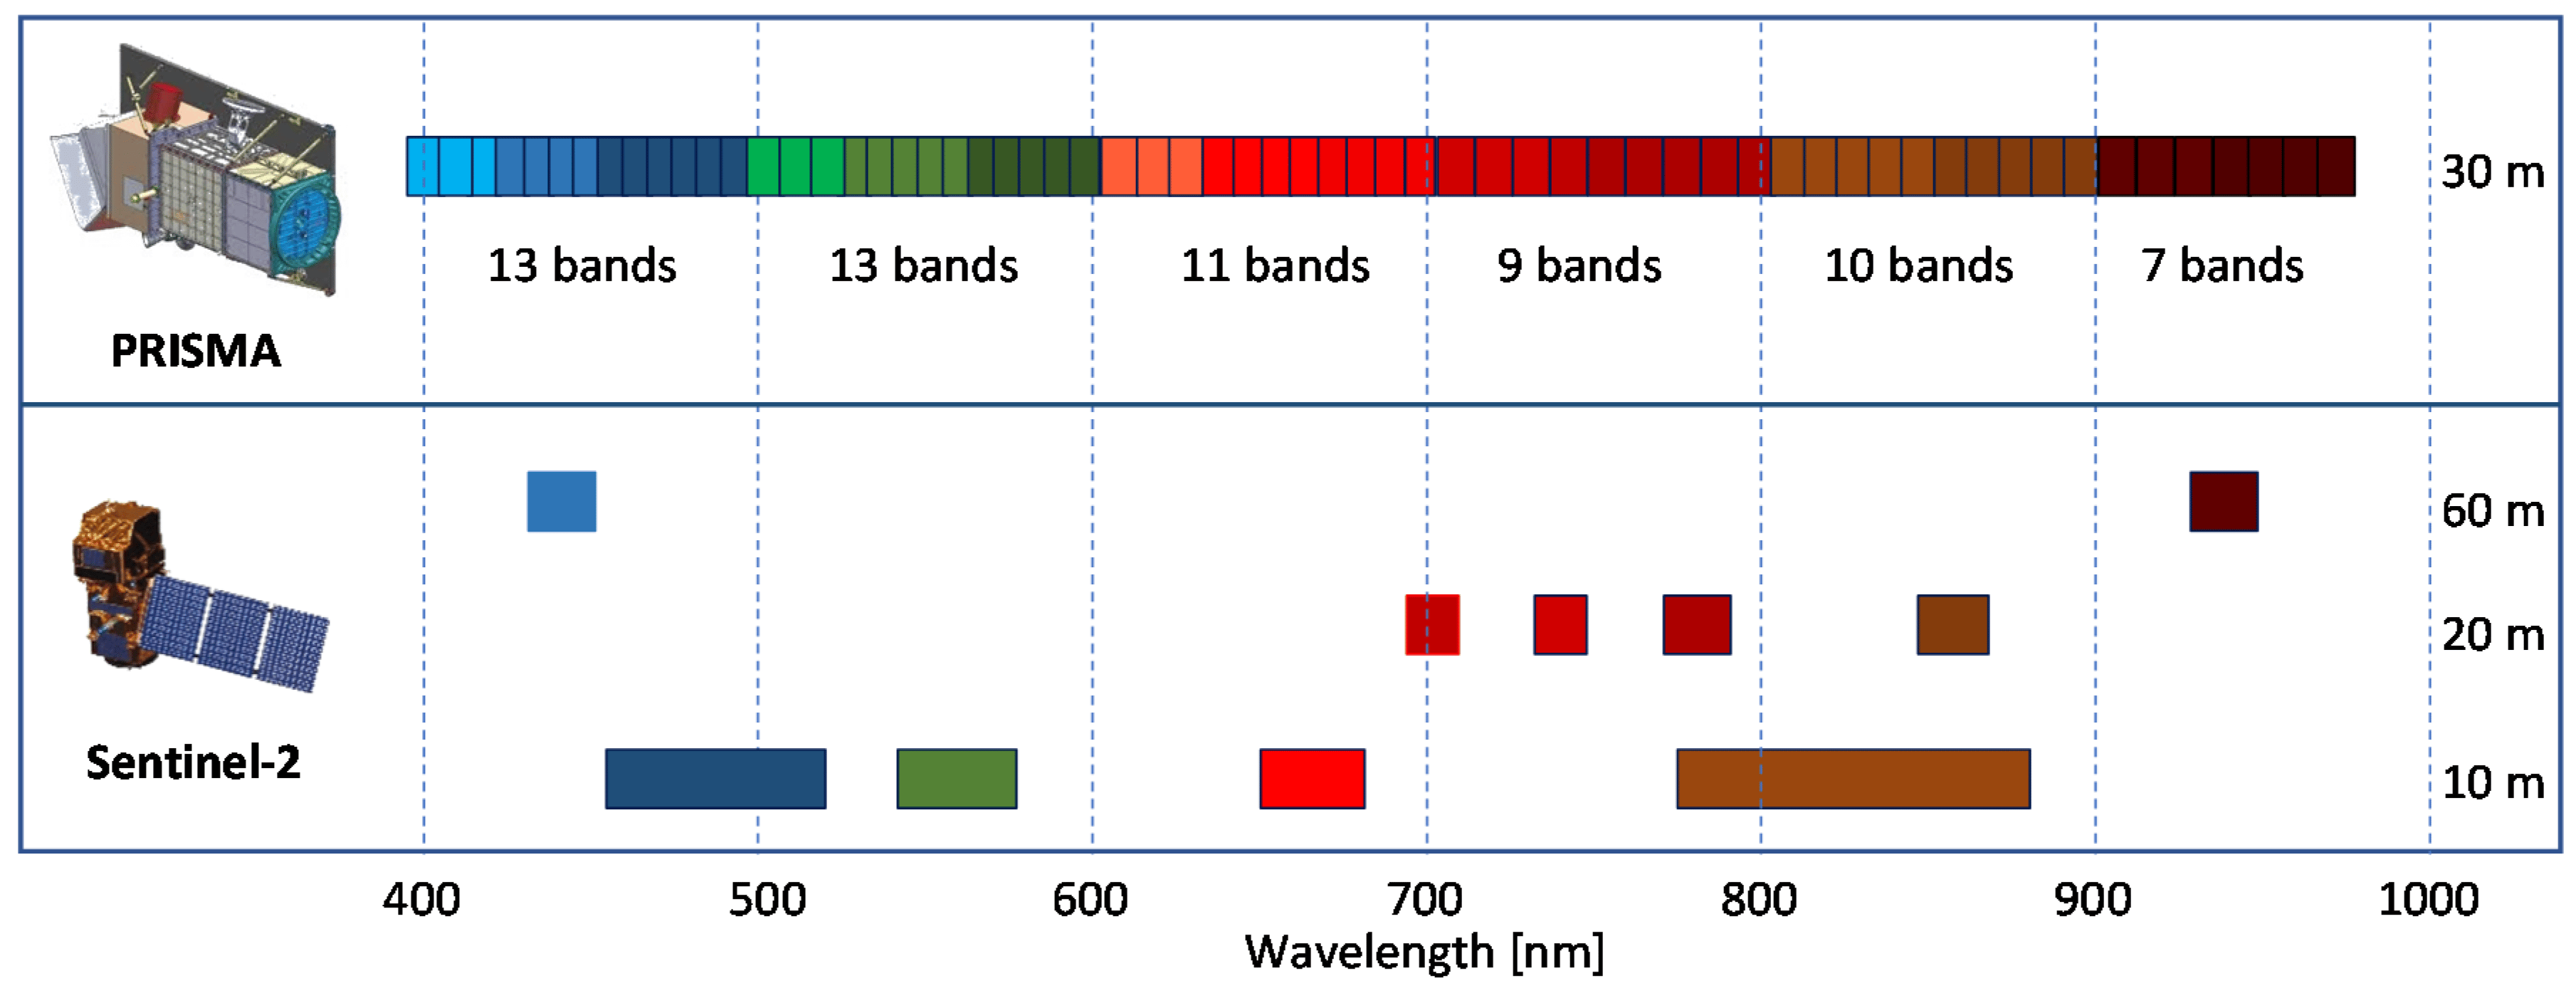
Niroumand-Jadidi, Milad & Bovolo, Francesca & Bruzzone, Lorenzo. (2020). Water Quality Retrieval from PRISMA Hyperspectral Images: First Experience in a Turbid Lake and Comparison with Sentinel-2. Remote Sensing. 12. 10.3390/rs12233984. 


## Import libraries

In [ ]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

import rasterio as rio
from rasterio import mask
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import h5py
import ipywidgets as widgets
from matplotlib.ticker import MultipleLocator
import seaborn as sns
import geopandas as gpd
from scipy.stats import linregress
import xml.dom.minidom


import IPython.display as display
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import matplotlib.ticker as ticker
from plotly import graph_objs as go

In [ ]:
# Import functions and set auto-reload
from functions_separability import *
%load_ext autoreload
%autoreload 2

# 1. Spectral signature plotting <a id='sec1'> </a>

[Back to top](#TOC_TOP)

## Pixel spectral signature

Open the PRISMA and Sentinel-2 files to retrieve the band central wavelengths:

In [ ]:
prisma_meta = h5py.File('./imagery_S2_PRISMA_raw/PRS_L2D_STD_20230209102412_20230209102416_0001.he5', 'r')
s2_meta = xml.dom.minidom.parse('./imagery_S2_PRISMA_raw/MTD_MSIL2A.xml')
wvl, wvl_dict, wvl_s = get_prisma_s2_wvl(prisma_meta, s2_meta)

Select the coregistered PRISMA hyperspectral cube (at 30 m resolution):

In [ ]:
date_prisma_w = widgets.Dropdown(
    options=['2023-02-09', '2023-03-22', '2023-04-08', '2023-06-17', '2023-07-10', '2023-08-08'],
    value='2023-02-09',
    description='PRISMA date:',
    disabled=False,
    layout={'width': 'max-content'},
    style = {'description_width': 'initial'}
)
date_prisma_w

Select the Sentinel-2 image (at 20 m resolution) with bands from B02 to B12:

In [ ]:
date_s2_w = widgets.Dropdown(
    options=['2023-02-10', '2023-03-22', '2023-04-26', '2023-06-25', '2023-07-10', '2023-08-19'],
    value='2023-02-10',
    description='Sentinel-2 date:',
    disabled=False,
    layout={'width': 'max-content'},
    style = {'description_width': 'initial'}
)
date_s2_w

In [ ]:
sel_s2_date = date_s2_w.value
sel_prisma_date = date_prisma_w.value
selected_prisma_image = 'PRISMA_outputs/coregistered/PR_'+ sel_prisma_date.replace('-', '') + '_30m.tif'
selected_s2_image = 'S2_outputs/S2_' + sel_s2_date.replace('-', '') + '_30m_all_bands_clip.tif'

print(f"The selected dates are --> Sentinel-2: {sel_s2_date} | PRISMA: {sel_prisma_date}.")
print(f"Selected Sentinel-2 image is --> {selected_s2_image}.")
print(f"The selected PRISMA image is --> {selected_prisma_image}.")

In [ ]:
with rio.open(selected_prisma_image) as src:
     data = src.read()

In [ ]:
with rio.open(selected_s2_image) as src_s:
    data_s = src_s.read()

In [ ]:
band_threshold = 1e-10
data = data.astype('float64')
data = data[~np.all(data <= band_threshold, axis=(1,2))]

In [ ]:
data.shape

The following function allows the user to interactively select a pixel. The spectral signature of the selected pixel will be displayed:

In [ ]:
#plot_signature_widgets(selected_prisma_image, wvl, wvl_s, data, data_s)

## Training sample spectral signature

This section is dedicated to the spectral signature plotting of the training samples.

Training samples are polygons representative of the following LCZ classes: (2) Compact mid-rise, (3) Compact low rise, (5) Open midrise, (6) Open low-rise, (8) Large low-rise, (101) Dense trees, (102) Scattered trees, (104) - Low plants, (105) Bare rock or paved, (106) Bare soil or sand, (107) Water.

Import the geopackages containing pre-defined training samples and the boundary of the area of interest (i.e. the Metropolitan City of Milan):

In [ ]:
training_folder = './layers/training_samples/training_set_' + sel_prisma_date.replace('-', '') + '.gpkg'
cmm_folder = './layers/CMM.gpkg'

Set a legend that defines the correspondence between the LCZ class, its description, and the color in the palette:

In [ ]:
legend = {
    2: ['Compact mid-rise', '#D10000'],
    3: ['Compact low-rise', '#CD0000'],
    5: ['Open mid-rise', '#FF6600'],
    6: ['Open low-rise', '#FF9955'],
    8: ['Large low-rise', '#BCBCBC'],
    101: ['Dense trees', '#006A00'],
    102: ['Scattered trees', '#00AA00'],
    104: ['Low plants', '#B9DB79'],
    105: ['Bare rock or paved', '#545454'],
    106: ['Bare soil or sand', '#FBF7AF'],
    107: ['Water', '#6A6AFF']
}

The following function displays an interactive map with the training samples. It also creates useful variables that will be used in the following.

In [ ]:
with rasterio.open(selected_prisma_image) as src:
    print(src)

In [ ]:
training, m, shapes = plot_training_samples(training_folder, cmm_folder, legend)

In [ ]:
m

Compute *median*, *mean*, and *standard deviation* of the *spectral signatures* of the training samples from **PRISMA**:

In [ ]:
spectral_sign_median, spectral_sign_mean, spectral_sign_std = compute_spectral_signature(selected_prisma_image, legend, shapes)

Compute *median*, *mean*, and *standard deviation* of the *spectral signatures* of the training samples from **Sentinel-2**:

In [ ]:
spectral_sign_median_s, spectral_sign_mean_s, spectral_sign_std_s = compute_spectral_signature(selected_s2_image, legend, shapes)

Compute *<u>single pixels</u> spectral signatures* of the training samples from **PRISMA**:

In [ ]:
pixels_spectral_sign = compute_pixel_spectral_signature(selected_prisma_image, legend, shapes)

Compute *<u>single pixels</u> spectral signatures* of the training samples from **Sentinel-2**:

In [ ]:
pixels_spectral_sign_s = compute_pixel_spectral_signature(selected_s2_image, legend, shapes)

Select the LCZ classes of interest. The median spectral signature, as well as the +/- standard deviation interval for the selected classes will be displayed in the following.

In [ ]:
LCZ_names = [value[0] for value in legend.values()]
checkboxes = [widgets.Checkbox(value=False, description=str(LCZ)) for LCZ in LCZ_names]
output = widgets.VBox(children=checkboxes)
output

In [ ]:
selected_LCZ_names = [checkbox.description for checkbox in checkboxes if checkbox.value]
selected_classes = [key for key, value in legend.items() if value[0] in selected_LCZ_names]

In [ ]:
sensor_w = widgets.RadioButtons(
    options = ['PRISMA', 'Sentinel-2'],
    description = 'Select the sensor: ',
    style = {'description_width': 'initial'}
)
sensor_w

#### Median and standard deviation of spectral signatures

In [ ]:
if sensor_w.value == 'PRISMA':
    plot_spectral_sign('PRISMA', wvl, wvl_s, selected_classes, spectral_sign_median, spectral_sign_std, legend)
else: plot_spectral_sign('Sentinel-2', wvl, wvl_s, selected_classes, spectral_sign_median_s, spectral_sign_std_s, legend)

#### Median and mean of spectral signatures

In [ ]:
if sensor_w.value == 'PRISMA':
    plot_spectral_sign_mean_median('PRISMA', wvl, wvl_s, selected_classes, spectral_sign_mean, spectral_sign_median, legend)
else: plot_spectral_sign_mean_median('Sentinel-2', wvl, wvl_s, selected_classes, spectral_sign_mean_s, spectral_sign_median_s, legend)

#### Comparison of PRISMA and Sentinel-2 spectral signatures

Lastly, the following interactive plot allows the user to easily compare the median spectral signatures of the training samples computed from both PRISMA and Sentinel-2. It is possible to select which LCZ classes will be displayed.

In [ ]:
positions = plot_spectral_sign_comparison(wvl, wvl_s, spectral_sign_median, spectral_sign_median_s, legend, selected_classes)

In [ ]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Assuming you have the necessary data structures (sorted(wvl), spectral_sign_median_s, spectral_sign_median, selected_classes, legend)

# # Set Seaborn theme
# sns.set_theme(style="ticks")

# fig, ax = plt.subplots(figsize=(8, 12))

# for LCZ in sorted(selected_classes):
#     sns.lineplot(x=sorted(wvl),
#                  y=[x for x in spectral_sign_median[LCZ] if not np.isnan(x)],
#                  linewidth=2, color=legend[LCZ][1],
#                  label=f"{legend[LCZ][0]}")

# # Customize the plot
# ax.set_xlabel("Wavelength (nm)", fontsize=13)
# ax.set_ylabel("Reflectance", fontsize=13)
# ax.set_title("Median spectral signature of training samples", fontsize=15)
# ax.set_ylim(0, 0.5)
# ax.set_xlim(400, 2500)

# # Add Seaborn tweaks
# sns.despine(trim=True)
# sns.set_context("paper")
# plt.xlim(left = 400, right = 2500)
# plt.ylim(bottom = 0.0, top = 0.5)
# plt.legend(loc='upper center', ncol = 3, bbox_to_anchor=(0.5, -0.2), fancybox=False, shadow=False, fontsize = 13, frameon = False)
# plt.subplots_adjust(left=0.1, right=0.9, bottom=0.4, top=0.8)

# # Save or display the plot
# #plt.savefig('./spectral_separability/spectral_sign_prisma_jun.png', dpi=300)
# plt.show()

In [ ]:
# # Assuming you have the necessary data structures (sorted(wvl), spectral_sign_median_s, spectral_sign_median, selected_classes, legend)

# # Set Seaborn theme
# sns.set_theme(style="ticks")

# fig, ax = plt.subplots(figsize=(8, 12))

# for LCZ in sorted(selected_classes):
#     sns.lineplot(x=sorted(wvl_s),
#                  y=[x for x in spectral_sign_median_s[LCZ] if not np.isnan(x)],
#                  linewidth=2, color=legend[LCZ][1],
#                  label=f"{legend[LCZ][0]}")

# # Customize the plot
# ax.set_xlabel("Wavelength (nm)", fontsize=13)
# ax.set_ylabel("Reflectance", fontsize=13)
# ax.set_title("Median spectral signature of training samples", fontsize=15)
# ax.set_ylim(0, 0.5)
# ax.set_xlim(400, 2500)

# # Add Seaborn tweaks
# sns.despine(trim=True)
# sns.set_context("paper")
# plt.xlim(left = 400, right = 2500)
# plt.ylim(bottom = 0.0, top = 0.5)

# plt.legend(loc='upper center', ncol = 3, bbox_to_anchor=(0.5, -0.2), fancybox=False, shadow=False, fontsize = 13, frameon = False)
# plt.subplots_adjust(left=0.1, right=0.9, bottom=0.4, top=0.8)

# # Save or display the plot
# plt.savefig('./spectral_separability/spectral_sign_s2_jun.png', dpi=300)
# plt.show()

## Boxplots of the training sample spectral signature

This part of the code computes the boxplots for each spectral band of the training polygons belonging to a specified LCZ class.

The following function displays the boxplots for the selected LCZ class for each PRISMA spectral band, corresponding to the pixels of the training samples.

In [ ]:
boxplot_training_samples(selected_prisma_image, shapes, legend, wvl_dict)

Finally, the following function displays a histogram of reflectance values for the specified class. The user can select the wavelength of interest through the interactive widget.

In [ ]:
histogram_training_samples(selected_prisma_image, shapes, legend, wvl_dict)

# 2. PRISMA band correlation
<a id='sec2'></a>
[Back to top](#TOC_TOP)

In this part of the Notebook, it is possible to explore the correlation between the spectral bands of PRISMA. The user can select the bands of interest through a widget. Correlation is measured on the pixels corresponding to the training samples.

Firstly, select the class and the bands of interest. The correlation will be computed accordingly.

In [ ]:
correlation_training_samples(selected_prisma_image, shapes, legend, wvl_dict)

<div class="alert alert-success">

# 3. Spectral separability
<a id='sec2'></a>
[Back to top](#TOC_TOP)

</div>

### Jeffries-Matusita Distance

The Jeffries-Matusita distance (JM distance) between two classes is calculated as:

$$ J_{xy} = 2\left(1-e^{-B}\right) $$

$$B = \frac{1}{8}(\mu_x - \mu_y)^T \cdot \left(\frac{\Sigma_{x} + \Sigma_{y}}{2}\right)^{-1} \cdot (\mu_x - \mu_y) + \frac{1}{2} \log \left(\frac{\frac{|\Sigma_{x} + \Sigma_{y}|}{2}}{\sqrt{|\Sigma_{x}| |\Sigma_{y}|}}\right)$$

where:
- $\mu_1$ and $\mu_2$ are the spectral signature vectors of classes $x$ and $y$,
- $\Sigma_{x}$ and $\Sigma_{y}$ are the covariance matrices of sample $x$ and $y$,
- $|\Sigma_{x}|$ and $|\Sigma_{y}|$ are the determinants of covariance matrices of sample $x$ and $y$.

### <u>**First possibility**</u>: manually select the classes of which you want to compute the distance.<br>
<u>For PRISMA, the distance is computed taking the one band every 10 bands</u>.

Select the classes:

In [ ]:
LCZ_names = [value[0] for value in legend.values()]
checkboxes = [widgets.Checkbox(value=False, description=str(LCZ)) for LCZ in LCZ_names]
output = widgets.HBox(children=checkboxes)
output

In [ ]:
selected_LCZ_names = [checkbox.description for checkbox in checkboxes if checkbox.value]
selected_classes = [key for key, value in legend.items() if value[0] in selected_LCZ_names]

Select the sensor:

In [ ]:
sensor_w = widgets.RadioButtons(
    options = ['PRISMA', 'Sentinel-2'],
    description = 'Select the satellite sensor:',
    style = {'description_width': 'initial'},
    disabled = False,
    continuous_update = False
)
sensor_w

In [ ]:
sensor = sensor_w.value

Compute the Jeffries-Matusita distance (if PRISMA is selected, one band every 10 bands is taken):

In [ ]:
jm_distance, mean_diff, cov_class1, cov_class2 = spectral_separability(selected_classes, legend, sensor, pixels_spectral_sign, pixels_spectral_sign_s)

### <u>**Second possibility**</u>: select the sensor (PRISMA or Sentinel-2), and automatically display the distance between all the class combinations.<br>
<u>For PRISMA, you can select how to sample the bands</u>:
* either you take PRISMA bands closest to Sentinel-2 bands,
* or you select one band every 10 bands [default option].

#### Select the sensor:

In [ ]:
sensor_w = widgets.RadioButtons(
    options = ['PRISMA', 'Sentinel-2'],
    description = 'Select the satellite sensor:',
    style = {'description_width': 'initial'},
    disabled = False,
    continuous_update = False
)
sensor_w

In [ ]:
sensor = sensor_w.value

In [ ]:
if sensor == 'PRISMA':
    sampling_w = widgets.RadioButtons(
        options = ['Bands closest to S2', '1 band every 10 bands'],
        value = '1 band every 10 bands',
        description = 'How do you want to sample PRISMA bands?',
        style = {'description_width': 'initial'},
        disabled = False,
        continuous_update = False
    )
else:
    sampling_w = None
sampling_w

In [ ]:
if sensor == 'PRISMA':
    sampling = sampling_w.value
else:
    sampling = None

The following function computes the spectral distance index for each couple of LCZ classes, for the selected sensor.

#### NOTE: if you want to compute the distance for both PRISMA and Sentinel-2, for comparison, run twice this code, and the results will be saved in separate dataframes.

In [ ]:
if sensor == 'PRISMA':
    results, df, jm_distance_df = spectral_separability_all_classes(legend, sensor, positions, sampling, pixels_spectral_sign, pixels_spectral_sign_s)
elif sensor == 'Sentinel-2':
    results_s, df_s, jm_distance_df_s = spectral_separability_all_classes(legend, sensor, positions, sampling, pixels_spectral_sign, pixels_spectral_sign_s)

In [ ]:
mapping_dict = {'2': 'Compact MR', '3': 'Compact LR', '5': 'Open MR', '6': 'Open LR', '8': 'Large LR', 
                      '101': 'Dense Trees', '102': 'Scatt Trees', 
                      '104': 'Low Plants', '105': 'Bare Rock Paved', '106': 'Bare Soil Sand', 
                      '107': 'Water'}

In [ ]:
mapped_values = pd.Series(df_s.index).str.split('-').apply(lambda x: ' - '.join([mapping_dict[key] for key in x]))

In [ ]:
df_s_new = df_s
df_new = df
df_s_new.index = mapped_values
df_new.index = mapped_values

In [ ]:
df_s_new

#### If you have computed the distances for both PRISMA and Sentinel-2, you can run the following code for performing comparisons

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x = df_new.index,
                         y = df_new['jm_distance'],
                         name = 'PRISMA',
                        mode = 'lines+markers'))
fig.add_trace(go.Scatter(x = df_s_new.index,
                         y = df_s_new['jm_distance'],
                         name = 'Sentinel-2',
                        mode = 'lines+markers'))
fig.update_layout(title = f'Jeffreis-Matusita distance - PRISMA image of {sel_prisma_date} and Sentinel-2 image of {sel_s2_date}',
                 width = 1200,
                 height = 500,
                 plot_bgcolor = 'white',
                 xaxis = dict(gridcolor = 'lightgrey'),
                 yaxis = dict(gridcolor = 'lightgrey'),
                 xaxis_tickangle =45)
fig.update_xaxes(title = 'Class pairs')
fig.update_yaxes(range=[0.5, 2.1])
fig.show()

#### Computation of the mean spectral distance (with +/- standard deviation) of each pair of classes

Select the classes for which you want to see the mean spectral distance:

In [ ]:
LCZ_names = [value[0] for value in legend.values()]
checkboxes = [widgets.Checkbox(value=False, description=str(LCZ)) for LCZ in LCZ_names]
output = widgets.VBox(children=checkboxes)
output

In [ ]:
selected_LCZ_names = [checkbox.description for checkbox in checkboxes if checkbox.value]
selected_classes = [key for key, value in legend.items() if value[0] in selected_LCZ_names]
index = (str(selected_classes[0]) + '-' + str(selected_classes[1]))

In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatter(x = [val for idx, val in enumerate(sorted(wvl)[::10]) if idx not in [11, 16]], 
                        y = df.loc[index]['mean_diff'], 
                        name = f'PRISMA',
                        mode = 'lines+markers'))

fig.add_trace(go.Scatter(x = wvl_s, 
                        y = df_s.loc[index]['mean_diff'], 
                        name = 'Sentinel-2',
                        mode = 'lines+markers'))
fig.update_layout(title = f'Mean spectral distance between {selected_classes[0]} ({selected_LCZ_names[0]}) and {selected_classes[1]} ({selected_LCZ_names[1]})', 
                  width = 800, 
                  height = 500)
fig.update_xaxes(title = 'Wavelength (nm)')
fig.update_yaxes(range = [-0.2, 0.1])
fig.show()

In [ ]:
classi = ["Compact Mid-rise","Compact Low-rise","Open Mid-rise","Open Low-rise","Large Low-rise",
          "Dense trees","Scattered trees","Low plants","Bare rock or paved","Bare soil or sand","Water"]
sep_prisma_9feb = np.array([[0,1.795,1.861,1.874,1.999,2,2,2,1.98,2,2],
                    [1.795,0,1.664,1.423,1.993,2,1.999,2,1.921,1.999,2],
                    [1.861,1.664,0,1.256,1.99,1.999,1.976,1.999,1.637,1.998,2],
                    [1.874,1.423,1.256,0,1.996,2,1.976,1.998,1.826,1.997,2],
                    [1.999,1.993,1.99,1.996,0,2,2,2,1.987,2,2],
                    [2,2,1.999,2,2,0,1.95,2,1.999,1.999,2],
                    [2,1.999,1.976,1.976,2,1.95,0,1.871,1.956,1.996,2],
                    [2,2,1.999,1.998,2,2,1.871,0,1.996,1.996,2],
                    [1.98,1.921,1.637,1.826,1.987,1.999,1.956,1.996,0,1.995,2],
                    [2,1.999,1.998,1.997,2,1.999,1.996,1.996,1.995,0,2],
                    [2,2,2,2,2,2,2,2,2,2,0]])
sep_s2_10feb = np.array([[0,1.617,1.529,1.443,1.912,2,1.999,2,1.742,1.976,1.997],
                        [1.617,0,1.609,1.614,1.719,1.996,1.985,1.995,1.85,1.921,1.997],
                        [1.529,1.609,0,1.019,1.844,1.993,1.936,1.99,1.387,1.939,1.998],
                        [1.443,1.614,1.019,0,1.916,1.993,1.873,1.979,1.485,1.927,2],
                        [1.912,1.719,1.844,1.916,0,1.992,1.982,1.997,1.864,1.928,1.998],
                        [2,1.996,1.993,1.993,1.992,0,1.809,1.999,1.984,1.972,2],
                        [1.999,1.985,1.936,1.873,1.982,1.809,0,1.658,1.83,1.945,2],
                        [2,1.995,1.99,1.979,1.997,1.999,1.658,0,1.985,1.983,2],
                        [1.742,1.85,1.387,1.485,1.864,1.984,1.83,1.985,0,1.915,1.998],
                        [1.976,1.921,1.939,1.927,1.928,1.972,1.945,1.983,1.915,0,1.998],
                        [1.997,1.997,1.998,2,1.998,2,2,2,1.998,1.998,0]])

sep_prisma_17jun = np.array([[0,1.877,1.907,1.958,2,2,2,2,1.978,2,2],
                           [1.877,0,1.85,1.703,2,2,2,2,1.965,1.999,2],
                           [1.907,1.85,0,1.67,2,2,1.994,2,1.84,1.994,2],
                           [1.958,1.703,1.67,0,2,2,1.994,1.997,1.91,1.992,2],
                           [2,2,2,2,0,2,2,2,2,2,2],
                           [2,2,2,2,2,0,1.97,1.999,2,2,2],
                           [2,2,1.994,1.994,2,1.97,0,1.928,1.994,1.999,2],
                           [2,2,2,1.997,2,1.999,1.928,0,1.999,1.999,2],
                           [1.978,1.965,1.84,1.91,2,2,1.994,1.999,0,1.991,2],
                           [2,1.999,1.994,1.992,2,2,1.999,1.999,1.991,0,2],
                           [2,2,2,2,2,2,2,2,2,2,0]])
sep_s2_25jun = np.array([[0,0.968,1.515,1.434,1.865,2,2,1.999,1.648,1.955,2],
                        [0.968,0,1.519,1.209,1.903,2,2,1.999,1.772,1.952,2],
                        [1.515,1.519,0,0.519,1.808,1.997,1.956,1.952,1.523,1.879,2],
                        [1.434,1.209,0.519,0,1.893,1.998,1.963,1.957,1.691,1.901,2],
                        [1.865,1.903,1.808,1.893,0,2,1.998,1.997,1.839,1.921,1.999],
                        [2,2,1.997,1.998,2,0,1.741,1.991,1.999,2,2],
                        [2,2,1.956,1.963,1.998,1.741,0,1.753,1.983,1.914,2],
                        [1.999,1.999,1.952,1.957,1.997,1.991,1.753,0,1.988,1.976,2],
                        [1.648,1.772,1.523,1.691,1.839,1.999,1.983,1.988,0,1.826,2],
                        [1.955,1.952,1.879,1.901,1.921,2,1.914,1.976,1.826,0,2],
                        [2,2,2,2,1.999,2,2,2,2,2,0]])

sep_prisma_8aug = np.array([[0,1.717,1.87,1.851,1.999,2,2,2,1.973,2,2],
                    [1.717,0,1.798,1.674,1.998,2,2,2,1.961,2,2],
                    [1.87,1.798,0,1.444,1.998,2,1.991,1.997,1.868,1.999,2],
                    [1.851,1.674,1.444,0,1.999,2,1.997,1.997,1.969,1.999,2],
                    [1.999,1.998,1.998,1.999,0,2,2,2,1.998,2,2],
                    [2,2,2,2,2,0,1.97,2,2,2,2],
                    [2,2,1.991,1.997,2,1.97,0,1.963,1.999,1.999,2],
                    [2,2,1.997,1.997,2,2,1.963,0,1.999,1.988,2],
                    [1.973,1.961,1.868,1.969,1.998,2,1.999,1.999,0,1.999,2],
                    [2,2,1.999,1.999,2,2,1.999,1.988,1.999,0,2],
                    [2,2,2,2,2,2,2,2,2,2,0]])
sep_s2_19aug = np.array([[0,0.971,1.406,1.46,1.859,2,2,2,1.666,1.999,2],
                        [0.971,0,1.25,1.144,1.901,2,2,2,1.761,1.997,2],
                        [1.406,1.25,0,0.539,1.903,1.988,1.937,1.981,1.61,1.966,2],
                        [1.46,1.144,0.539,0,1.948,1.996,1.959,1.98,1.829,1.976,2],
                        [1.859,1.901,1.903,1.948,0,2,2,1.999,1.862,1.988,1.999],
                        [2,2,1.988,1.996,2,0,1.847,1.988,2,2,2],
                        [2,2,1.937,1.959,2,1.847,0,1.743,1.997,1.877,2],
                        [2,2,1.981,1.98,1.999,1.988,1.743,0,1.998,1.835,2],
                        [1.666,1.761,1.61,1.829,1.862,2,1.997,1.998,0,1.98,2],
                        [1.999,1.997,1.966,1.976,1.988,2,1.877,1.835,1.98,0,2],
                        [2,2,2,2,1.999,2,2,2,2,2,0]])

In [ ]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="white")

# Create a DataFrame from the matrix
prisma = pd.DataFrame(data=sep_prisma_9feb)
s2 = pd.DataFrame(data=sep_s2_10feb)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(prisma, dtype=bool))

# Set up the matplotlib figure
f, ax1 = plt.subplots(figsize=(10, 10))
plt.tight_layout()

# Generate a custom diverging colormap
#cmap = sns.diverging_palette(230, 20, as_cmap=True)
cmap = 'viridis'
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(prisma, ax = ax1, mask=mask, cmap=cmap, vmin=0.5, vmax=2, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5, "use_gridspec": True},
            annot=True, fmt=".2f", annot_kws={"fontsize": 10, "color": 'black'})

# Set x and y ticks
ax1.set_xticks(np.arange(len(classi)) + 0.5)
ax1.set_yticks(np.arange(len(classi)) + 0.5)

# Set x and y tick labels
ax1.set_xticklabels(classi, rotation = 90, ha = "right", fontsize = 13)
ax1.set_yticklabels(classi, rotation = 0, va = "center", fontsize = 13)
ax1.set_title('Jeffries Matusita distance\nPRISMA', fontweight = 'bold', fontsize = 15)

plt.subplots_adjust(left = 0.18, right = 0.8, bottom = 0.2, top = 0.9)
plt.savefig('spectral_separability/sep_prisma_february.png', dpi = 300)
plt.show()

In [ ]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="white")

# Create a DataFrame from the matrix
prisma = pd.DataFrame(data=sep_prisma_9feb)
s2 = pd.DataFrame(data=sep_s2_10feb)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(s2, dtype=bool))

# Set up the matplotlib figure
f, ax1 = plt.subplots(figsize=(10, 10))
plt.tight_layout()

# Generate a custom diverging colormap
#cmap = sns.diverging_palette(230, 20, as_cmap=True)
cmap = 'viridis'
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(s2, ax = ax1, mask=mask, cmap=cmap, vmin=0.5, vmax=2, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5, "use_gridspec": True},
            annot=True, fmt=".2f", annot_kws={"fontsize": 10, "color": 'black'})

# Set x and y ticks
ax1.set_xticks(np.arange(len(classi)) + 0.5)
ax1.set_yticks(np.arange(len(classi)) + 0.5)

# Set x and y tick labels
ax1.set_xticklabels(classi, rotation = 90, ha = "right", fontsize = 13)
ax1.set_yticklabels(classi, rotation = 0, va = "center", fontsize = 13)
ax1.set_title('Jeffries Matusita distance\nSentinel-2', fontweight = 'bold', fontsize = 15)

plt.subplots_adjust(left = 0.18, right = 0.8, bottom = 0.2, top = 0.9)
plt.savefig('spectral_separability/sep_s2_february.png', dpi = 300)
plt.show()

In [ ]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="white")

# Create a DataFrame from the matrix
prisma = pd.DataFrame(data=sep_prisma_17jun)
s2 = pd.DataFrame(data=sep_s2_25jun)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(prisma, dtype=bool))

# Set up the matplotlib figure
f, ax1 = plt.subplots(figsize=(10, 10))
plt.tight_layout()

# Generate a custom diverging colormap
#cmap = sns.diverging_palette(230, 20, as_cmap=True)
cmap = 'viridis'
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(prisma, ax = ax1, mask=mask, cmap=cmap, vmin=0.5, vmax=2, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5, "use_gridspec": True},
            annot=True, fmt=".2f", annot_kws={"fontsize": 10, "color": 'black'})

# Set x and y ticks
ax1.set_xticks(np.arange(len(classi)) + 0.5)
ax1.set_yticks(np.arange(len(classi)) + 0.5)

# Set x and y tick labels
ax1.set_xticklabels(classi, rotation = 90, ha = "right", fontsize = 13)
ax1.set_yticklabels(classi, rotation = 0, va = "center", fontsize = 13)
ax1.set_title('Jeffries Matusita distance\nPRISMA', fontweight = 'bold', fontsize = 15)

plt.subplots_adjust(left = 0.18, right = 0.8, bottom = 0.2, top = 0.9)
plt.savefig('spectral_separability/sep_prisma_june.png', dpi = 300)
plt.show()

In [ ]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="white")

# Create a DataFrame from the matrix
prisma = pd.DataFrame(data=sep_prisma_17jun)
s2 = pd.DataFrame(data=sep_s2_25jun)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(s2, dtype=bool))

# Set up the matplotlib figure
f, ax1 = plt.subplots(figsize=(10, 10))
plt.tight_layout()

# Generate a custom diverging colormap
#cmap = sns.diverging_palette(230, 20, as_cmap=True)
cmap = 'viridis'
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(s2, ax = ax1, mask=mask, cmap=cmap, vmin=0.5, vmax=2, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5, "use_gridspec": True},
            annot=True, fmt=".2f", annot_kws={"fontsize": 10, "color": 'black'})

# Set x and y ticks
ax1.set_xticks(np.arange(len(classi)) + 0.5)
ax1.set_yticks(np.arange(len(classi)) + 0.5)

# Set x and y tick labels
ax1.set_xticklabels(classi, rotation = 90, ha = "right", fontsize = 13)
ax1.set_yticklabels(classi, rotation = 0, va = "center", fontsize = 13)
ax1.set_title('Jeffries Matusita distance\nSentinel-2', fontweight = 'bold', fontsize = 15)

plt.subplots_adjust(left = 0.18, right = 0.8, bottom = 0.2, top = 0.9)
plt.savefig('spectral_separability/sep_s2_june.png', dpi = 300)
plt.show()

In [ ]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="white")

# Create a DataFrame from the matrix
prisma = pd.DataFrame(data=sep_prisma_8aug)
s2 = pd.DataFrame(data=sep_s2_19aug)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(s2, dtype=bool))

# Set up the matplotlib figure
f, ax1 = plt.subplots(figsize=(10, 10))
plt.tight_layout()

# Generate a custom diverging colormap
#cmap = sns.diverging_palette(230, 20, as_cmap=True)
cmap = 'viridis'
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(s2, ax = ax1, mask=mask, cmap=cmap, vmin=0.5, vmax=2, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5, "use_gridspec": True},
            annot=True, fmt=".2f", annot_kws={"fontsize": 10, "color": 'black'})

# Set x and y ticks
ax1.set_xticks(np.arange(len(classi)) + 0.5)
ax1.set_yticks(np.arange(len(classi)) + 0.5)

# Set x and y tick labels
ax1.set_xticklabels(classi, rotation = 90, ha = "right", fontsize = 13)
ax1.set_yticklabels(classi, rotation = 0, va = "center", fontsize = 13)
ax1.set_title('Jeffries Matusita distance\nSentinel-2', fontweight = 'bold', fontsize = 15)

plt.subplots_adjust(left = 0.18, right = 0.8, bottom = 0.2, top = 0.9)
plt.savefig('spectral_separability/sep_s2_august.png', dpi = 300)
plt.show()

In [ ]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="white")

# Create a DataFrame from the matrix
prisma = pd.DataFrame(data=sep_prisma_8aug)
s2 = pd.DataFrame(data=sep_s2_19aug)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(prisma, dtype=bool))

# Set up the matplotlib figure
f, ax1 = plt.subplots(figsize=(10, 10))
plt.tight_layout()

# Generate a custom diverging colormap
#cmap = sns.diverging_palette(230, 20, as_cmap=True)
cmap = 'viridis'
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(prisma, ax = ax1, mask=mask, cmap=cmap, vmin=0.5, vmax=2, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5, "use_gridspec": True},
            annot=True, fmt=".2f", annot_kws={"fontsize": 10, "color": 'black'})

# Set x and y ticks
ax1.set_xticks(np.arange(len(classi)) + 0.5)
ax1.set_yticks(np.arange(len(classi)) + 0.5)

# Set x and y tick labels
ax1.set_xticklabels(classi, rotation = 90, ha = "right", fontsize = 13)
ax1.set_yticklabels(classi, rotation = 0, va = "center", fontsize = 13)
ax1.set_title('Jeffries Matusita distance\nPRISMA', fontweight = 'bold', fontsize = 15)

plt.subplots_adjust(left = 0.18, right = 0.8, bottom = 0.2, top = 0.9)
plt.savefig('spectral_separability/sep_prisma_august.png', dpi = 300)
plt.show()